## Introduction
For the past months, many businesses have been affected by a large increase of uncertainty in many areas of operations. In particular, negative impact has been felt in the supply-chain and logistics domain with many suppliers being unable to deliver products downstream. Inspired by these challenging circumstances, I want to share in this post a quick idea on how to potentially model demand at an item level plus account for randomness in demand. The items will sell at low volumes, i.e. we will see many zeros within the time-series.  

For our model, this means that a continuous approximation might yield fairly unreasonable results as applicability of central limit theorems are far from being justifiable. We would also likely fail to properly account for the high probability of selling exactly zero items which might result in fairly misguided decisions. 

But let's just start with the data!

In [1]:
ENV["JULIA_CUDA_SILENT"]=true

using Flux
using Zygote
using Plots
using CSV
using Distributions
using Random
using Queryverse
using Dates

## Dataset and preliminaries
The dataset is a pretty generic set of [sales data from an unnamed company](https://www.kaggle.com/jyotiprasadpal/historical-sales-data-on-daily-basis-of-a-company) over different items and countries:

In [2]:
df = CSV.File("Historical_Data.csv") |> DataFrame 

,Date,Article_ID,Country_Code,Sold_Units
,Int64,Int64,String,Int64
1,20170817,1132,AT,1
2,20170818,1132,AT,1
3,20170821,1132,AT,1
4,20170822,1132,AT,1
5,20170906,1132,AT,1
6,20170920,1132,AT,1
7,20170921,1132,AT,1
8,20170922,1132,AT,1
9,20170923,1132,AT,1


For convenience, we simply use the data for *Article_ID==1132* sold solely in *Country_Code=="AT"*.

In [3]:
data = df |> @filter(_.Country_Code=="AT" && _.Article_ID==1132) |> @select(:Date, :Sold_Units) |> DataFrame
data.Date = Date.(string.(data.Date),"yyyymmdd")

245-element Array{Date,1}:
 2017-08-17
 2017-08-18
 2017-08-21
 2017-08-22
 2017-09-06
 2017-09-20
 2017-09-21
 2017-09-22
 2017-09-23
 2017-09-24
 2017-09-27
 2017-09-30
 2017-10-09
 ⋮
 2019-01-26
 2019-01-27
 2019-01-29
 2019-02-03
 2019-02-04
 2019-02-06
 2019-02-07
 2019-02-08
 2019-02-10
 2019-02-11
 2019-02-12
 2019-02-13

Also, the dataset only contains dates with non-zero units sold. In order to build a proper forecast model, we create two vectors containing all dates in the observed period and all sales volumes (zeros included) respectively.

In [4]:
dates = collect(minimum(data.Date):Day(1):maximum(data.Date)) 

T = size(dates)[1]

sales = zeros(T)

for i in 1:T
    if dates[i] in data.Date
        sales[i] = data.Sold_Units[data.Date.==dates[i]][1]
    end
end

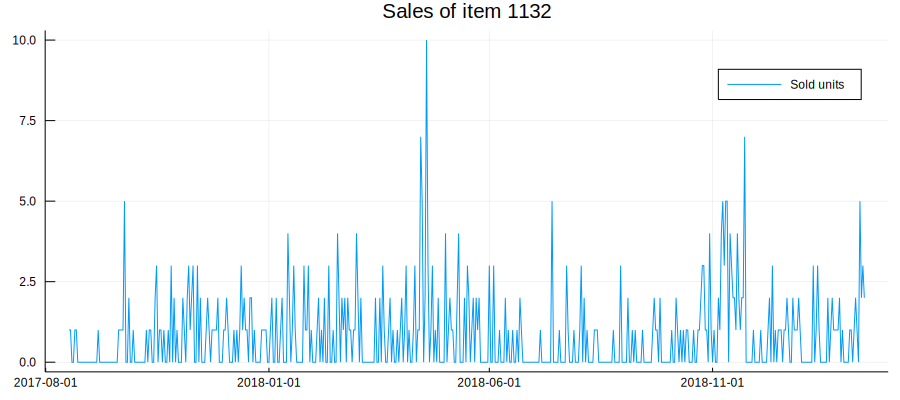

In [5]:
plot(dates, sales, title="Sales of item 1132", label="Sold units", size=(900,400))

We see that the demand never crosses 10 items per day and that there exists a non-neglgible amount of days with no sales at all. All of this should be accounted for in our model.

## The model
In summary, our ideal model should account at least for the following:
- Forecast values should be non-negative integers
- Error intervals should be reasonable and only contain non-negative values as well
- Our whole model should be end-to-end differentiable to enable efficient parameter optimization  

Luckily, all of the above can be achieved with a [Poisson-Distribution](https://en.wikipedia.org/wiki/Poisson_distribution):  

$$p_{Pois}(y;\lambda)=\frac{\lambda^y\cdot exp(-\lambda))}{y!}\cdot\mathbb{I}_{(y\in\mathbb{Z}^+_0)}(y)$$  

As we see, the Poisson distribution only puts probability mass on non-zero integers. In addition, $\lambda\in\mathbb{R}^+$, hence we can differentiate through all distribution parameters.  

We can now formulate the actual forecasting model:  

$$sales_{t}\sim Pois(\Lambda_{t})$$  

$$\Lambda_{t}=exp\left(\Phi(sales_{(t-1:t-14)})\right)$$  

Here, $\Phi(\cdot)$ denotes an arbitrary non-linear function - we can simply plug-in a Feedforward Neural Network.
$sales_{(t-1:t-14)}$ is a vector of lagged realizations of items sold, i.e. the past 14 sales datapoints before the day we want to forecast. Obviously, the model is very simplistic and we should ideally add more features in a real-world use-case.

In [6]:
lag = 14

lagged_sales = Matrix(zeros(lag, T-lag))
for t in 1:T-lag
    for l in 1:lag 
        lagged_sales[l,t] = sales[t-1+l]
    end
end

In [7]:
lagged_sales

14×532 Array{Float64,2}:
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  …  1.0  1.0  1.0  2.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0     1.0  1.0  2.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0     1.0  2.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     2.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  1.0  0.0  1.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  1.0  0.0  1.0  2.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  0.0  1.0  2.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  2.0  1.0  0.0  5.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [8]:
y_sales = sales[lag+1:end]

532-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 1.0
 1.0
 0.0
 1.0
 2.0
 1.0
 0.0
 5.0
 2.0
 3.0
 2.0

For this introductory example, we will also only do one-step ahead testing and not perform a forecast over a longer time-horizon. In a real-world problem, you should only do this if really only the next day is relevant. In case your model needs to forecast over a longer time-horizon, you need to account for this in your testing and validation steps.  

(Side-note: For this stochastic model with lagged auto-predictors, you would need to do Monte-Carlo simulations in order to correctly do an $X$-step ahead forecast with $X>1$)

In [9]:
X_train = lagged_sales[:,1:end-100]
X_test = lagged_sales[:,end-99:end]

y_train = y_sales[1:end-100]
y_test = y_sales[end-99:end]

100-element Array{Float64,1}:
 1.0
 4.0
 5.0
 3.0
 5.0
 5.0
 0.0
 4.0
 3.0
 2.0
 2.0
 1.0
 4.0
 ⋮
 0.0
 1.0
 1.0
 0.0
 1.0
 2.0
 1.0
 0.0
 5.0
 2.0
 3.0
 2.0

As mentioned above, we simply use a Feedforward Network for $\Phi$ - both layer-topology and activation function were chosen quite arbitrarily and would likely need to be optimized in application. Also, we need to ensure that the output is positive as the output will be used as the strictly-positive parameter of the Poisson-Distribution. 

In [10]:
Random.seed!(321)
model = Chain(Dense(lag,10,selu), Dense(10,10,selu), Dense(10,1), x->exp.(x))

Chain(Dense(14, 10, selu), Dense(10, 10, selu), Dense(10, 1), #11)

In order to estimate the model parameters, we use Maximum-Likelihood. That means that we use the estimated forecast-distribution for each day and optimize its parameters to maximize the likelihood of the actually observed sales value for that day. If you are new to Maximum-Likelihood methods, I highly recommend to read up on them as Maximum-Likelihood is a very powerful tool.

In [11]:
function poisson_loglike(model, X, y)
    λ = model(X)[:]
    -mean(y.*log.(λ) .- λ .- log.(factorial.(y)))
end

poisson_loglike (generic function with 1 method)

The next cell is not necessary but makes working with Flux+Zygote more convenient to myself.

In [12]:
loss() = poisson_loglike(model, X_train, y_train)

loss (generic function with 1 method)

Now we can grab the model parameters, define the optimizer and 'learn' our model parameters.

In [13]:
params = Flux.params(model)
opt = ADAM(0.01)

ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}())

In [14]:
for i in 1:100
    grads = Zygote.gradient(()->loss(), params)
    Flux.Optimise.update!(opt, params, grads)
    if i%10==0 || i==1
        println(loss())
    end
end 

2.3574069243831053
1.6750365382562786
1.3895055795570306
1.2740624072475433
1.2446403356783775
1.2213983698600446
1.2036021462600761
1.188941886716236
1.1771252793193157
1.1669957317098294
1.157933156883795


## Evaluation
Finally, we can perform the one-step ahead forecast on our hold-out set:

In [15]:
prob_forecast = Poisson.(Float64.(model(X_test)[:]))

100-element Array{Poisson{Float64},1}:
 Poisson{Float64}(λ=0.847226619720459)
 Poisson{Float64}(λ=0.9192099571228027)
 Poisson{Float64}(λ=1.4431120157241821)
 Poisson{Float64}(λ=0.8316798806190491)
 Poisson{Float64}(λ=2.348788261413574)
 Poisson{Float64}(λ=2.5310475826263428)
 Poisson{Float64}(λ=1.9020497798919678)
 Poisson{Float64}(λ=2.5985312461853027)
 Poisson{Float64}(λ=2.0054309368133545)
 Poisson{Float64}(λ=0.45134299993515015)
 Poisson{Float64}(λ=0.3537631630897522)
 Poisson{Float64}(λ=0.7592843770980835)
 Poisson{Float64}(λ=0.5059677362442017)
 ⋮
 Poisson{Float64}(λ=0.6818021535873413)
 Poisson{Float64}(λ=0.5880723595619202)
 Poisson{Float64}(λ=0.7180291414260864)
 Poisson{Float64}(λ=0.6849886775016785)
 Poisson{Float64}(λ=0.9069685935974121)
 Poisson{Float64}(λ=0.9222384691238403)
 Poisson{Float64}(λ=1.0099505186080933)
 Poisson{Float64}(λ=0.642636239528656)
 Poisson{Float64}(λ=0.8596776723861694)
 Poisson{Float64}(λ=1.0555813312530518)
 Poisson{Float64}(λ=0.47326332330703735)

Now since we have full distributional forecasts, we can also obtain interesting summary statistics. We are mostly interested in a point forecast and an interval forecast, so we use mean and 90% confidence interval (CI):

In [16]:
mean_forecast = mean.(prob_forecast)
lower_forecast = quantile.(prob_forecast, 0.05)
upper_forecast = quantile.(prob_forecast, 0.95)

plot(mean_forecast; ribbon=(mean_forecast .- lower_forecast, upper_forecast .- mean_forecast),
    size=(900, 400), lw=3, line=:dash, label="Mean Forecast", title="One-Day ahead forecast")

plot!(mode_forecast, lw=3, line=:dash, label="Mode Forecast")

plot!(y_test, lw=3, label="Actual Realization")

UndefVarError: UndefVarError: mode_forecast not defined

After the above qualitative inspection, we should also consider some quantitative evaluation metrics. Here, we look at the CI coverage - 90% of actual values should fall into the 90% CI, none more and none less - and at the Mean Absolute Error (MAE) of our point forecast.

In [17]:
println("90% CI-coverage:")
println(mean((lower_forecast .<= y_test) .* (upper_forecast .>= y_test)))
println()
println("Forecast MAE:")
println(mean(abs.(mean_forecast .- y_test)))

90% CI-coverage:
0.91

Forecast MAE:
1.0060239964723587


The CI-coverage looks reasonable - 91% of actual values fall within our forecast 90% CI. The MAE looks ok-ish given the low range of the data. Using more data, features or or a better tuned model, we could fairly likely arrive at better results for the point-forecast.

## What's the advantage?
One might ask why to go the extra steps of a discrete Poisson model for item level demand when we could simply use the output of the Neural Network as the demand forecast, given that it will also be strictly positive. There are several reasons that speak against this procedure:

1) **The real process cannot be continuous**: While all models are necessarily wrong in the absence of complete knowledge about the underlying problem and absence of data, we should strive to get our models as close to reality as possible

2) **Communicating results can be done much more conveniently**: Since we have point mass at a countable set of realizations, we can tell decision makers exactly what numbers to expect at what probabilities. This is certainly not as straightforward with a continuous forecast, given said forecast is probabilistic at all (a lognormal model would be possible but again violate the discrete nature of the time series)

3) **There is a rich toolset for optimization with discrete probabilities**: Continuous stochastic optimization is also a well developed field yet working with discrete probabilities makes things much easier. Some optimization techniques might even only be possible with discrete probabilities. With reliable demand forecasts about a whole inventory at hand, one could easily answer interesting questions - e.g. how many units per item to order in order to maximize expected returns given costs for order and storage. 

On the other hand, the Poisson model is of course fairly simplistic as the distribution uses a single parameter ($\lambda$) to describe a fairly complex real-world process. Depending on the data available, one might want to try more sophisticated distributions to better account for this. 

## Conclusion
Hopefully, the above was inspiring enough to take a deeper look at non-standard, probabilistic regression models. In past blog-posts I have mostly introduced non-probabilistic regresion models myself but things only become interesting and actually realistic if you take the randomness and stochasticity of the real-world into account. At the moment, I am also working a lot with Bayesian Machine Learning for my PhD thesis which is actually completely separate from the topics I wrote about so far. This will change as soon as I have blog-able results at hand :)